### Dependencies
Custom-built with PyTorch.

In [1]:
%pip install torch torchvision pytorch-lightning matplotlib numpy


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /opt/homebrew/opt/python@3.10/bin/python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
import pytorch_lightning as pl
import numpy

In [3]:
### Set ENV variables.
seed = 42
torch.manual_seed(seed)

BATCH_SIZE=128
NUM_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS=int(os.cpu_count() / 2)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

### Data Preprocessing
GAN is trained on MNIST image data.

In [4]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir='./data', batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,),)
            ]
        )

    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        if stage == 'test' or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers, persistent_workers=True)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size/2, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size/2, num_workers=self.num_workers)

### Model Construction

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_1 = nn.Conv2d(1, 10, kernel_size=5)
        self.norm_1 = nn.BatchNorm2d(10)
        self.conv_2 = nn.Conv2d(10, 20, kernel_size=5)
        self.drop = nn.Dropout2d()
        self.norm_2 = nn.BatchNorm2d(20)

        self.linear_1 = nn.Linear(320, 50)
        self.norm_lin = nn.LayerNorm(50)
        self.linear_2 = nn.Linear(50, 1)

    def forward(self, x):
        x = self.norm_1(self.conv_1(x))
        x = F.relu(F.max_pool2d(x, 2))
        x = self.norm_2(self.drop(self.conv_2(x)))
        x = F.relu(F.max_pool2d(x, 2))

        x = x.view(-1, 320)
        x = F.relu(self.norm_lin(self.linear_1(x)))
        x = F.dropout(x, training=self.training)
        x = self.linear_2(x)
        return F.sigmoid(x)

In [6]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.linear = nn.Linear(latent_dim, 7*7*64)
        self.norm_lin = nn.LayerNorm(7*7*64)

        self.transpose_1 = nn.ConvTranspose2d(64, 32, 4, stride=2)
        self.norm_1 = nn.BatchNorm2d(32)
        self.transpose_2 = nn.ConvTranspose2d(32, 16, 4, stride=2)
        self.norm_2 = nn.BatchNorm2d(16)

        self.conv = nn.Conv2d(16, 1, kernel_size=7)

    def forward(self, x):
        x = self.linear(x)
        x = F.relu(self.norm_lin(x))
        x = x.view(-1, 64, 7, 7)

        x = F.relu(self.norm_1(self.transpose_1(x)))
        x = F.relu(self.norm_2(self.transpose_2(x)))

        return self.conv(x)

In [7]:
class GAN(pl.LightningModule):
    def __init__(self, latent_dim=100, lr=0.0002):
        super().__init__()
        self.save_hyperparameters()
        self.automatic_optimization = False # Must manually set optimizers.

        self.generator = Generator(latent_dim=self.hparams.latent_dim)
        self.discriminator = Discriminator()

        self.validation_z = torch.randn(6, self.hparams.latent_dim) #

    def forward(self, z):
        return self.generator(z)

    def adversarial_loss(self, y_pred, y):
        return F.binary_cross_entropy(y_pred, y)

    def training_step(self, batch, batch_idx):
        imgs, _ = batch

        gen_opt, dis_opt = self.optimizers()
        y_real = torch.ones(imgs.shape[0], 1).to(DEVICE)
        y_fake = torch.zeros(imgs.shape[0], 1).to(DEVICE)

        # Create sample noise.
        z = torch.randn(imgs.shape[0], self.hparams.latent_dim).type_as(imgs)

        ### Optimize generator.
        gen_imgs = self(z)
        y_pred = self.discriminator(gen_imgs)
        g_loss = self.adversarial_loss(y_pred, y_real)

        gen_opt.zero_grad()
        self.manual_backward(g_loss)
        gen_opt.step()


        ### Optimize discriminator.
        y_pred_real = self.discriminator(imgs)
        real_loss = self.adversarial_loss(y_pred_real, y_real)

        y_pred_fake = self.discriminator(self(z).detach())
        fake_loss = self.adversarial_loss(y_pred_fake, y_fake)

        d_loss = real_loss + fake_loss

        dis_opt.zero_grad()
        self.manual_backward(d_loss)
        dis_opt.step()

        self.log_dict({'g_loss': g_loss, 'd_loss': d_loss}, prog_bar=True)


    def configure_optimizers(self):
        lr = self.hparams.lr
        opt_gen = torch.optim.Adam(self.generator.parameters(), lr=lr)
        opt_disc = torch.optim.Adam(self.discriminator.parameters(), lr=lr)
        return [opt_gen, opt_disc], []


    def plot_imgs(self):
        z = self.validation_z.type_as(self.generator.linear.weight)
        sample_imgs = self(z).cpu()

        fig = plt.figure()
        for i in range(sample_imgs.size(0)):
            plt.subplot(2, 3, i+1)
            plt.tight_layout()
            plt.imshow(sample_imgs.detach()[i, 0, ...].numpy(), cmap='gray_r', interpolation='none')
            plt.title('Generated Data')
            plt.xticks([])
            plt.yticks([])
            plt.axis('off')

        plt.show()

    def on_train_epoch_end(self):
        self.plot_imgs()


### Training Loop

In [8]:
dm = MNISTDataModule()
model = GAN()

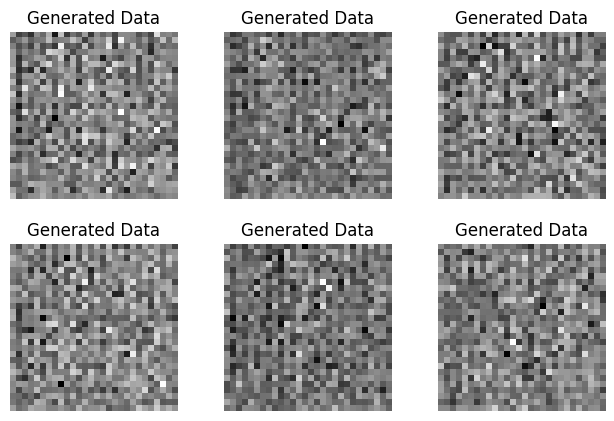

In [9]:
model.plot_imgs()

In [10]:
trainer = pl.Trainer(max_epochs=20)
trainer.fit(model, dm)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/opt/homebrew/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/opt/homebrew/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.

  | N

Epoch 0:   0%|          | 0/430 [00:00<?, ?it/s]

RuntimeError: Placeholder storage has not been allocated on MPS device!